In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import random
from Bio import pairwise2
from Bio.Seq import Seq
import time
from sklearn.preprocessing import normalize
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
train_seqs = pd.read_csv('/kaggle/input/stanford-rna-3d-folding-2/train_sequences.csv')
valid_seqs = pd.read_csv('/kaggle/input/stanford-rna-3d-folding-2/validation_sequences.csv')
test_seqs = pd.read_csv('/kaggle/input/stanford-rna-3d-folding-2/test_sequences.csv')
train_labels = pd.read_csv('/kaggle/input/stanford-rna-3d-folding-2/train_labels.csv')
valid_labels = pd.read_csv('/kaggle/input/stanford-rna-3d-folding-2/validation_labels.csv')

In [3]:
print(f"Loaded {len(train_seqs)} training sequences, {len(valid_seqs)} validation sequences, and {len(test_seqs)} test sequences")

Loaded 5716 training sequences, 28 validation sequences, and 28 test sequences


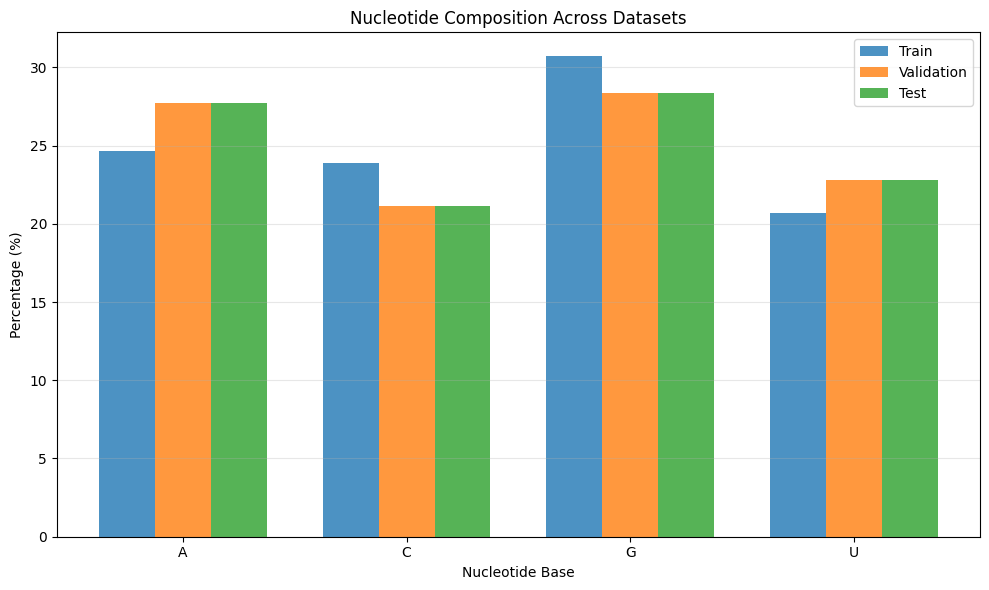

In [4]:
def plot_base_composition():
    """
    Plot the nucleotide composition across different datasets.
    """
    def get_base_counts(seqs_df):
        bases = {'A': 0, 'C': 0, 'G': 0, 'U': 0}
        for seq in seqs_df['sequence']:
            for base in seq:
                if base in bases:
                    bases[base] += 1
        total = sum(bases.values())
        return {k: v/total * 100 for k, v in bases.items()}
    
    train_comp = get_base_counts(train_seqs)
    valid_comp = get_base_counts(valid_seqs)
    test_comp = get_base_counts(test_seqs)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(4)
    width = 0.25
    bases = ['A', 'C', 'G', 'U']
    
    ax.bar(x - width, [train_comp[b] for b in bases], width, label='Train', alpha=0.8)
    ax.bar(x, [valid_comp[b] for b in bases], width, label='Validation', alpha=0.8)
    ax.bar(x + width, [test_comp[b] for b in bases], width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Nucleotide Base')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Nucleotide Composition Across Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(bases)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

plot_base_composition()

In [5]:
# Process training labels to create a dictionary mapping target_id to its 3D coordinates
def process_labels(labels_df):
    """
    Process labels dataframe to create a dictionary mapping target_id to coordinates
    """
    coords_dict = {}
    
    # Group by target ID
    for id_prefix, group in labels_df.groupby(lambda x: labels_df['ID'][x].rsplit('_', 1)[0]):
        # Extract just the coordinates columns for the first structure (x_1, y_1, z_1)
        coords = []
        for _, row in group.sort_values('resid').iterrows():
            coords.append([row['x_1'], row['y_1'], row['z_1']])
        
        coords_dict[id_prefix] = np.array(coords)
    
    return coords_dict

# Process training labels
print("Processing training labels...")
train_coords_dict = process_labels(train_labels)
valid_coords_dict = process_labels(valid_labels)
print(f"Processed coordinates for {len(train_coords_dict)} training structures and {len(valid_coords_dict)} validation structures")

Processing training labels...
Processed coordinates for 5716 training structures and 28 validation structures


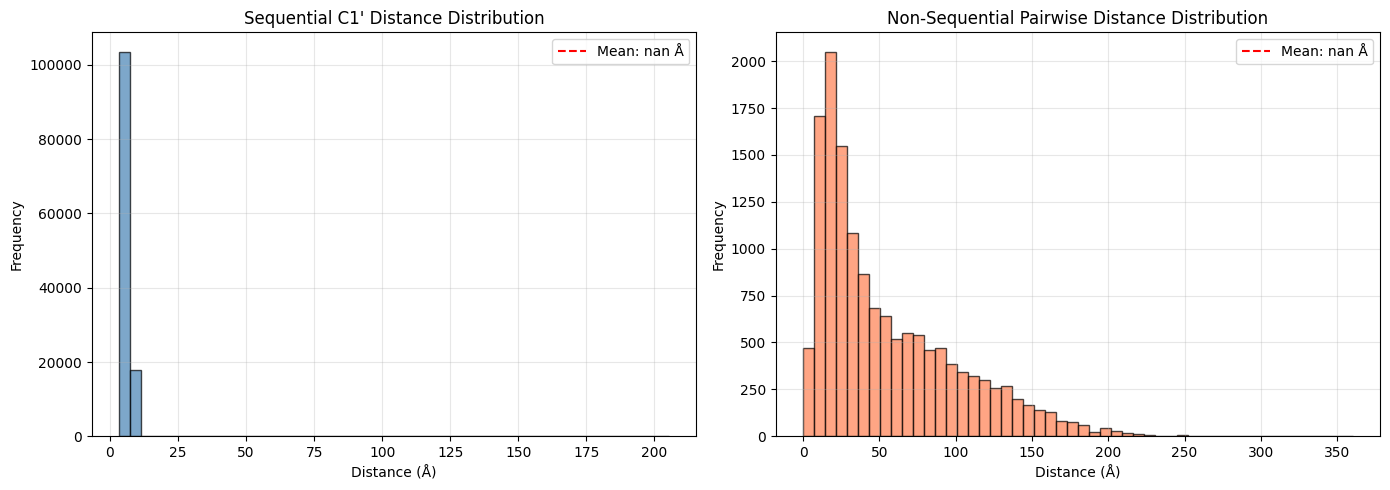

In [6]:
def plot_distance_distributions(coords_dict, sample_size=100):
    """
    Plot distributions of sequential and pairwise distances in training structures.
    INSERT: After processing training labels (after line ~47)
    """
    sequential_dists = []
    all_pairwise_dists = []
    
    # Sample structures to avoid computational overload
    sampled_ids = random.sample(list(coords_dict.keys()), min(sample_size, len(coords_dict)))
    
    for target_id in sampled_ids:
        coords = coords_dict[target_id]
        
        # Sequential distances (consecutive nucleotides)
        for i in range(len(coords) - 1):
            dist = np.linalg.norm(coords[i+1] - coords[i])
            sequential_dists.append(dist)
        
        # Sample pairwise distances (to avoid memory issues)
        if len(coords) > 2:
            sample_indices = random.sample(range(len(coords)), min(20, len(coords)))
            for i in range(len(sample_indices)):
                for j in range(i+2, len(sample_indices)):  # Skip consecutive
                    dist = np.linalg.norm(coords[sample_indices[i]] - coords[sample_indices[j]])
                    all_pairwise_dists.append(dist)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sequential distances
    axes[0].hist(sequential_dists, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0].axvline(np.mean(sequential_dists), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(sequential_dists):.2f} Å')
    axes[0].set_xlabel('Distance (Å)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Sequential C1\' Distance Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # All pairwise distances
    axes[1].hist(all_pairwise_dists, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[1].axvline(np.mean(all_pairwise_dists), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_pairwise_dists):.2f} Å')
    axes[1].set_xlabel('Distance (Å)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Non-Sequential Pairwise Distance Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
plot_distance_distributions(train_coords_dict, sample_size=100)

In [7]:
# Function to find similar sequences in the training data
def find_similar_sequences(query_seq, train_seqs_df, train_coords_dict, temporal_cutoff=None, top_n=5):
    """
    Find sequences in the training data that are similar to the query sequence,
    respecting temporal cutoffs if provided.
    
    Args:
        query_seq: The RNA sequence to find templates for
        train_seqs_df: DataFrame containing training sequences
        train_coords_dict: Dictionary mapping target_ids to their 3D coordinates
        temporal_cutoff: Only consider training sequences published before this date
        top_n: Number of top templates to return
        
    Returns:
        List of (target_id, sequence, similarity_score, coordinates) tuples
    """
    similar_seqs = []
    
    # Convert query to Seq object for alignment
    query_seq_obj = Seq(query_seq)
    
    # Filter training sequences by temporal cutoff if provided
    if temporal_cutoff:
        filtered_train_seqs = train_seqs_df[train_seqs_df['temporal_cutoff'] < temporal_cutoff]
    else:
        filtered_train_seqs = train_seqs_df
    
    for _, row in filtered_train_seqs.iterrows():
        target_id = row['target_id']
        train_seq = row['sequence']
        
        # Skip if coordinates not available
        if target_id not in train_coords_dict:
            continue
            
        # Skip if sequence is too different in length (more than 50% difference)
        if abs(len(train_seq) - len(query_seq)) / max(len(train_seq), len(query_seq)) > 0.5:
            continue
        
        # Perform sequence alignment
        # We're using global alignment with gap open penalty of -10 and gap extension penalty of -0.5
        alignments = pairwise2.align.globalms(query_seq_obj, train_seq, 2, -1, -10, -0.5, one_alignment_only=True)
        
        if alignments:
            alignment = alignments[0]
            similarity_score = alignment.score / (2 * min(len(query_seq), len(train_seq)))
            similar_seqs.append((target_id, train_seq, similarity_score, train_coords_dict[target_id]))
    
    # Sort by similarity score (higher is better) and return top N
    similar_seqs.sort(key=lambda x: x[2], reverse=True)
    return similar_seqs[:top_n]

In [8]:
def adaptive_rna_constraints(coordinates, sequence, confidence=1.0):
    """
    Apply RNA geometric constraints with adaptive strength based on confidence.
    
    Args:
        coordinates: Array of 3D coordinates, shape (len(sequence), 3)
        sequence: RNA sequence string
        confidence: Float between 0 and 1 indicating confidence in template 
                   (higher = less constraint enforcement)
        
    Returns:
        Refined coordinates
    """
    # Make a copy of coordinates to refine
    refined_coords = coordinates.copy()
    n_residues = len(sequence)
    
    # Calculate constraint strength (inverse of confidence)
    # High confidence templates receive gentler constraints
    constraint_strength = 0.8 * (1.0 - min(confidence, 0.8))
    
    # 1. Sequential distance constraints (consecutive nucleotides)
    # More flexible distance range (statistical distribution from PDB)
    seq_min_dist = 5.5  # Minimum sequential distance
    seq_max_dist = 6.5  # Maximum sequential distance
    
    for i in range(n_residues - 1):
        current_pos = refined_coords[i]
        next_pos = refined_coords[i+1]
        
        # Calculate current distance
        current_dist = np.linalg.norm(next_pos - current_pos)
        
        # Only adjust if significantly outside expected range
        if current_dist < seq_min_dist or current_dist > seq_max_dist:
            # Calculate target distance (midpoint of range)
            target_dist = (seq_min_dist + seq_max_dist) / 2
            
            # Get direction vector
            direction = next_pos - current_pos
            direction = direction / (np.linalg.norm(direction) + 1e-10)
            
            # Apply partial adjustment based on constraint strength
            adjustment = (target_dist - current_dist) * constraint_strength
            
            # Only adjust the next position to preserve the overall fold
            refined_coords[i+1] = current_pos + direction * (current_dist + adjustment)
    
    # 2. Steric clash prevention (more conservative)
    min_allowed_distance = 3.8  # Minimum distance between non-consecutive C1' atoms
    
    # Calculate all pairwise distances
    dist_matrix = distance_matrix(refined_coords, refined_coords)
    
    # Find severe clashes (atoms too close)
    severe_clashes = np.where((dist_matrix < min_allowed_distance) & (dist_matrix > 0))
    
    # Fix severe clashes
    for idx in range(len(severe_clashes[0])):
        i, j = severe_clashes[0][idx], severe_clashes[1][idx]
        
        # Skip consecutive nucleotides and previously processed pairs
        if abs(i - j) <= 1 or i >= j:
            continue
            
        # Get current positions and distance
        pos_i = refined_coords[i]
        pos_j = refined_coords[j]
        current_dist = dist_matrix[i, j]
        
        # Calculate necessary adjustment but scale by constraint strength
        direction = pos_j - pos_i
        direction = direction / (np.linalg.norm(direction) + 1e-10)
        
        # Calculate partial adjustment
        adjustment = (min_allowed_distance - current_dist) * constraint_strength
        
        # Move points apart
        refined_coords[i] = pos_i - direction * (adjustment / 2)
        refined_coords[j] = pos_j + direction * (adjustment / 2)
    
    # 3. Very light base-pair constraining (if confidence is low)
    if constraint_strength > 0.3:  # Only apply if template confidence is low
        # Simple Watson-Crick base pairs
        pairs = {'A': 'U', 'U': 'A', 'G': 'C', 'C': 'G'}
        
        # Scan for potential base pairs
        for i in range(n_residues):
            base_i = sequence[i]
            complement = pairs.get(base_i)
            
            if not complement:
                continue
                
            # Look for complementary bases within a reasonable range
            for j in range(i + 3, min(i + 20, n_residues)):
                if sequence[j] == complement:
                    # Calculate current distance
                    current_dist = np.linalg.norm(refined_coords[i] - refined_coords[j])
                    
                    # Only consider if distance suggests potential pairing
                    if 8.0 < current_dist < 14.0:
                        # Target 10.5Å as generic base-pair C1'-C1' distance
                        target_dist = 10.5
                        
                        # Calculate very gentle adjustment (scaled by constraint_strength)
                        adjustment = (target_dist - current_dist) * (constraint_strength * 0.3)
                        
                        # Get direction vector
                        direction = refined_coords[j] - refined_coords[i]
                        direction = direction / (np.linalg.norm(direction) + 1e-10)
                        
                        # Apply very gentle adjustment to both positions
                        refined_coords[i] = refined_coords[i] - direction * (adjustment / 2)
                        refined_coords[j] = refined_coords[j] + direction * (adjustment / 2)
                        
                        # Only consider one potential pair per base (closest match)
                        break
    
    return refined_coords

In [9]:
def adapt_template_to_query(query_seq, template_seq, template_coords, alignment=None):
    """
    Adapt template coordinates to fit the query sequence based on sequence alignment,
    with robust handling of gaps and NaN values.
    
    Args:
        query_seq: The target RNA sequence
        template_seq: The template RNA sequence
        template_coords: 3D coordinates of the template
        alignment: Optional pre-computed alignment
        
    Returns:
        Array of adapted coordinates for the query sequence
    """
    if alignment is None:
        # Perform sequence alignment
        from Bio.Seq import Seq
        from Bio import pairwise2
        
        query_seq_obj = Seq(query_seq)
        template_seq_obj = Seq(template_seq)
        alignments = pairwise2.align.globalms(query_seq_obj, template_seq_obj, 2, -1, -10, -0.5, one_alignment_only=True)
        
        if not alignments:
            # If alignment fails, return a basic structure
            return generate_basic_structure(query_seq)
            
        alignment = alignments[0]
    
    # Extract aligned sequences
    aligned_query = alignment.seqA
    aligned_template = alignment.seqB
    
    # Initialize coordinates for query sequence
    query_coords = np.zeros((len(query_seq), 3))
    query_coords.fill(np.nan)  # Fill with NaN initially to track unmapped positions
    
    # Map template coordinates to query
    query_idx = 0
    template_idx = 0
    
    for i in range(len(aligned_query)):
        query_char = aligned_query[i]
        template_char = aligned_template[i]
        
        if query_char != '-' and template_char != '-':
            # Both sequences have a residue at this position
            if template_idx < len(template_coords):
                query_coords[query_idx] = template_coords[template_idx]
            template_idx += 1
            query_idx += 1
        elif query_char != '-' and template_char == '-':
            # Gap in template - will handle these gaps in post-processing
            query_idx += 1
        elif query_char == '-' and template_char != '-':
            # Gap in query, skip this template position
            template_idx += 1
    
    # Post-processing step: Fill in any NaN positions
    # First pass: handle isolated NaNs surrounded by valid coordinates
    for i in range(len(query_coords)):
        if np.isnan(query_coords[i, 0]):
            # Find nearest valid coordinates before and after
            prev_valid = -1
            for j in range(i-1, -1, -1):
                if not np.isnan(query_coords[j, 0]):
                    prev_valid = j
                    break
                    
            next_valid = -1
            for j in range(i+1, len(query_coords)):
                if not np.isnan(query_coords[j, 0]):
                    next_valid = j
                    break
            
            # Interpolate if we have valid points on both sides
            if prev_valid >= 0 and next_valid >= 0:
                # Linear interpolation
                weight = (i - prev_valid) / (next_valid - prev_valid)
                query_coords[i] = (1 - weight) * query_coords[prev_valid] + weight * query_coords[next_valid]
    
    # Second pass: handle remaining NaNs (at start, end, or long stretches)
    typical_step = 4.0  # Typical nucleotide distance in Angstroms
    
    for i in range(len(query_coords)):
        if np.isnan(query_coords[i, 0]):
            # If this is the first position with NaN
            if i == 0:
                # Look for the first valid position
                first_valid = -1
                for j in range(1, len(query_coords)):
                    if not np.isnan(query_coords[j, 0]):
                        first_valid = j
                        break
                
                if first_valid >= 0:
                    # Work backwards from the first valid position
                    for j in range(first_valid-1, -1, -1):
                        # Create a random direction for the step
                        direction = np.random.normal(0, 1, 3)
                        direction = direction / (np.linalg.norm(direction) + 1e-10) * typical_step
                        query_coords[j] = query_coords[j+1] - direction
                else:
                    # No valid positions at all, create a basic structure
                    for j in range(len(query_coords)):
                        angle = j * 0.6
                        query_coords[j] = [10.0 * np.cos(angle), 10.0 * np.sin(angle), j * 2.5]
                    break  # Exit the loop as we've filled all positions
            else:
                # Not the first position, look for previous valid position
                prev_valid = -1
                for j in range(i-1, -1, -1):
                    if not np.isnan(query_coords[j, 0]):
                        prev_valid = j
                        break
                
                if prev_valid >= 0:
                    # We have a valid previous position
                    if prev_valid > 0 and not np.isnan(query_coords[prev_valid-1, 0]):
                        # We have two previous valid positions, continue the direction
                        direction = query_coords[prev_valid] - query_coords[prev_valid-1]
                        direction = direction / (np.linalg.norm(direction) + 1e-10) * typical_step
                        query_coords[i] = query_coords[prev_valid] + direction
                    else:
                        # Just one previous valid position, create a random step
                        direction = np.random.normal(0, 1, 3)
                        direction = direction / (np.linalg.norm(direction) + 1e-10) * typical_step
                        query_coords[i] = query_coords[prev_valid] + direction
                else:
                    # No valid previous positions (unusual case), start from origin
                    query_coords[i] = np.array([0.0, 0.0, 0.0]) + np.random.normal(0, 1, 3) * i
    
    # Verify no NaNs remain
    if np.isnan(query_coords).any():
        # Final fallback: replace any remaining NaNs with zeros
        query_coords = np.nan_to_num(query_coords)
    
    return query_coords

def generate_basic_structure(sequence):
    """
    Generate a simple helical structure for a sequence when alignment fails.
    
    Args:
        sequence: RNA sequence string
        
    Returns:
        Array of 3D coordinates
    """
    n_residues = len(sequence)
    coordinates = np.zeros((n_residues, 3))
    
    # Create a simple helix
    radius = 10.0
    rise_per_residue = 2.5
    angle_per_residue = 0.6
    
    for i in range(n_residues):
        angle = i * angle_per_residue
        coordinates[i] = [
            radius * np.cos(angle), 
            radius * np.sin(angle), 
            i * rise_per_residue
        ]
    
    return coordinates


# Function to create a more realistic RNA structure when no good templates are found
def generate_rna_structure(sequence, seed=None):
    """
    Generate a more realistic RNA structure prediction for a given sequence.
    
    Args:
        sequence: RNA sequence (string of A, C, G, U)
        seed: Random seed for reproducibility
        
    Returns:
        coordinates: Array of shape (len(sequence), 3) with x, y, z coordinates
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    
    n_residues = len(sequence)
    coordinates = np.zeros((n_residues, 3))
    
    # Initialize the first few residues in a helix
    for i in range(min(3, n_residues)):
        angle = i * 0.6
        coordinates[i] = [10.0 * np.cos(angle), 10.0 * np.sin(angle), i * 2.5]
    
    # Add more complex folding patterns
    current_direction = np.array([0.0, 0.0, 1.0])  # Start moving along z-axis
    
    # Define base-pairing tendencies (G-C and A-U pairs)
    for i in range(3, n_residues):
        # Check for potential base-pairing in the sequence
        has_pair = False
        pair_idx = -1
        
        # Simple detection of complementary bases (G-C, A-U)
        complementary = {'G': 'C', 'C': 'G', 'A': 'U', 'U': 'A'}
        current_base = sequence[i]
        
        # Look for potential base-pairing within a window before the current position
        window_size = min(i, 15)  # Look back up to 15 bases
        for j in range(i-window_size, i):
            if j >= 0 and sequence[j] == complementary.get(current_base, 'X'):
                # Found a potential pair
                has_pair = True
                pair_idx = j
                break
        
        if has_pair and i - pair_idx <= 10 and random.random() < 0.7:
            # Try to create a base-pair by positioning this nucleotide near its pair
            pair_pos = coordinates[pair_idx]
            
            # Create a position that's roughly opposite to the pair
            random_offset = np.random.normal(0, 1, 3) * 2.0
            base_pair_distance = 10.0 + random.uniform(-1.0, 1.0)
            
            # Calculate a vector from base-pair toward center of structure
            center = np.mean(coordinates[:i], axis=0)
            direction = center - pair_pos
            direction = direction / (np.linalg.norm(direction) + 1e-10)
            
            # Position new nucleotide in the general direction of the "center"
            coordinates[i] = pair_pos + direction * base_pair_distance + random_offset
            
            # Update direction for next nucleotide
            current_direction = np.random.normal(0, 0.3, 3)
            current_direction = current_direction / (np.linalg.norm(current_direction) + 1e-10)
            
        else:
            # No base-pairing detected, continue with the current fold direction
            # Randomly rotate current direction to simulate RNA flexibility
            if random.random() < 0.3:
                # More significant direction change
                angle = random.uniform(0.2, 0.6)
                axis = np.random.normal(0, 1, 3)
                axis = axis / (np.linalg.norm(axis) + 1e-10)
                rotation = R.from_rotvec(angle * axis)
                current_direction = rotation.apply(current_direction)
            else:
                # Small random changes in direction
                current_direction += np.random.normal(0, 0.15, 3)
                current_direction = current_direction / (np.linalg.norm(current_direction) + 1e-10)
            
            # Distance between consecutive nucleotides (3.5-4.5Å is typical)
            step_size = random.uniform(3.5, 4.5)
            
            # Update position
            coordinates[i] = coordinates[i-1] + step_size * current_direction
    
    return coordinates


In [10]:
def predict_rna_structures(sequence, target_id, train_seqs_df, train_coords_dict, n_predictions=5, temporal_cutoff=None):
    predictions = []
    
    # Find similar sequences in the training data
    similar_seqs = find_similar_sequences(sequence, train_seqs_df, train_coords_dict, 
                                         temporal_cutoff=temporal_cutoff, top_n=n_predictions)
    
    # If we found any similar sequences, use them as templates
    if similar_seqs:
        for i, (template_id, template_seq, similarity, template_coords) in enumerate(similar_seqs):
            # Adapt template coordinates to the query sequence
            adapted_coords = adapt_template_to_query(sequence, template_seq, template_coords)
            
            if adapted_coords is not None:
                # Apply adaptive constraints based on template similarity
                # For high similarity templates, apply very gentle constraints
                refined_coords = adaptive_rna_constraints(adapted_coords, sequence, confidence=similarity)
                
                # Add some randomness (less for better templates)
                random_scale = max(0.05, 0.8 - similarity)  # Reduced randomness
                randomized_coords = refined_coords.copy()
                randomized_coords += np.random.normal(0, random_scale, randomized_coords.shape)
                
                predictions.append(randomized_coords)
                
                if len(predictions) >= n_predictions:
                    break
    
    # If we don't have enough predictions from templates, generate de novo structures
    while len(predictions) < n_predictions:
        seed_value = hash(target_id) % 10000 + len(predictions) * 1000
        de_novo_coords = generate_rna_structure(sequence, seed=seed_value)
        
        # Apply stronger constraints to de novo structures (lower confidence)
        refined_de_novo = adaptive_rna_constraints(de_novo_coords, sequence, confidence=0.2)
        
        predictions.append(refined_de_novo)
    
    return predictions[:n_predictions]

In [11]:
def plot_template_similarity_distribution(test_seqs_sample, train_seqs_df, train_coords_dict, n_samples=50):
    """
    Plot distribution of template similarity scores found for test sequences.
    """
    similarity_scores = []
    
    sampled_test = test_seqs_sample.sample(min(n_samples, len(test_seqs_sample)))
    
    for _, row in sampled_test.iterrows():
        sequence = row['sequence']
        temporal_cutoff = row.get('temporal_cutoff', None)
        
        similar_seqs = find_similar_sequences(sequence, train_seqs_df, train_coords_dict, 
                                            temporal_cutoff=temporal_cutoff, top_n=5)
        
        for _, _, sim_score, _ in similar_seqs:
            similarity_scores.append(sim_score)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(similarity_scores, bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
    ax.axvline(np.mean(similarity_scores), color='red', linestyle='--', 
              label=f'Mean: {np.mean(similarity_scores):.3f}')
    ax.axvline(np.median(similarity_scores), color='orange', linestyle='--', 
              label=f'Median: {np.median(similarity_scores):.3f}')
    ax.set_xlabel('Template Similarity Score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Template Similarity Scores\n(Sampled from {n_samples} test sequences)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_prediction_comparison(target_id, sequence, predictions):
    """
    Plot all 5 predictions for a single target to visualize ensemble diversity.
    """
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(5):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        coords = predictions[i]
        
        # Plot backbone
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 'b-', alpha=0.6, linewidth=1.5)
        
        # Plot residues
        colors = {'A': 'red', 'C': 'blue', 'G': 'green', 'U': 'orange'}
        for j, base in enumerate(sequence):
            color = colors.get(base, 'gray')
            ax.scatter(coords[j, 0], coords[j, 1], coords[j, 2], 
                      c=color, s=30, alpha=0.7)
        
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title(f'Prediction {i+1}')
        
    fig.suptitle(f'5 Structure Predictions for {target_id}\nSequence length: {len(sequence)} nt', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

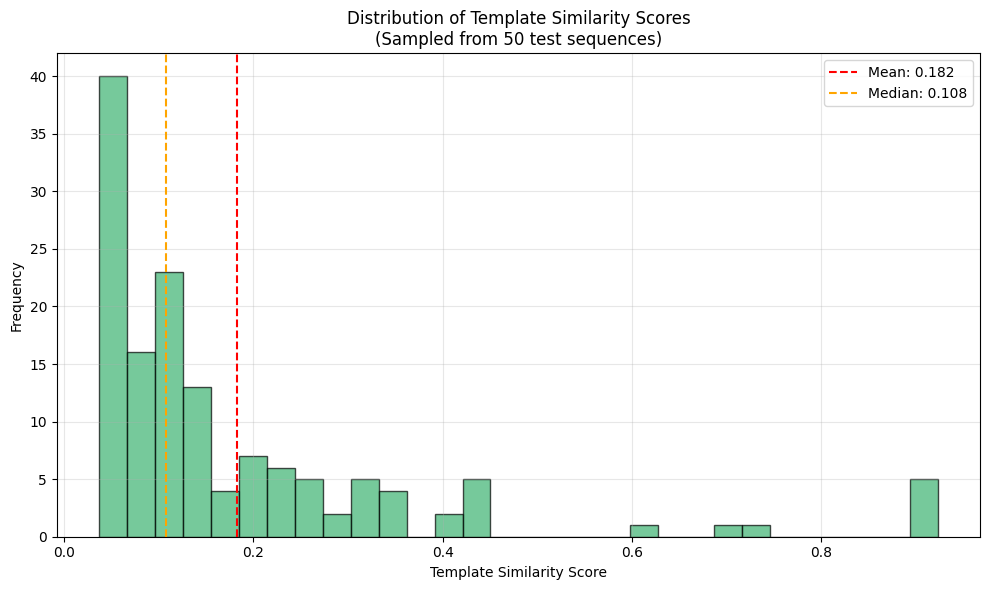

Processing target 1/28: 8ZNQ (30 nt), elapsed: 2603.6s, est. remaining: 70296.1s


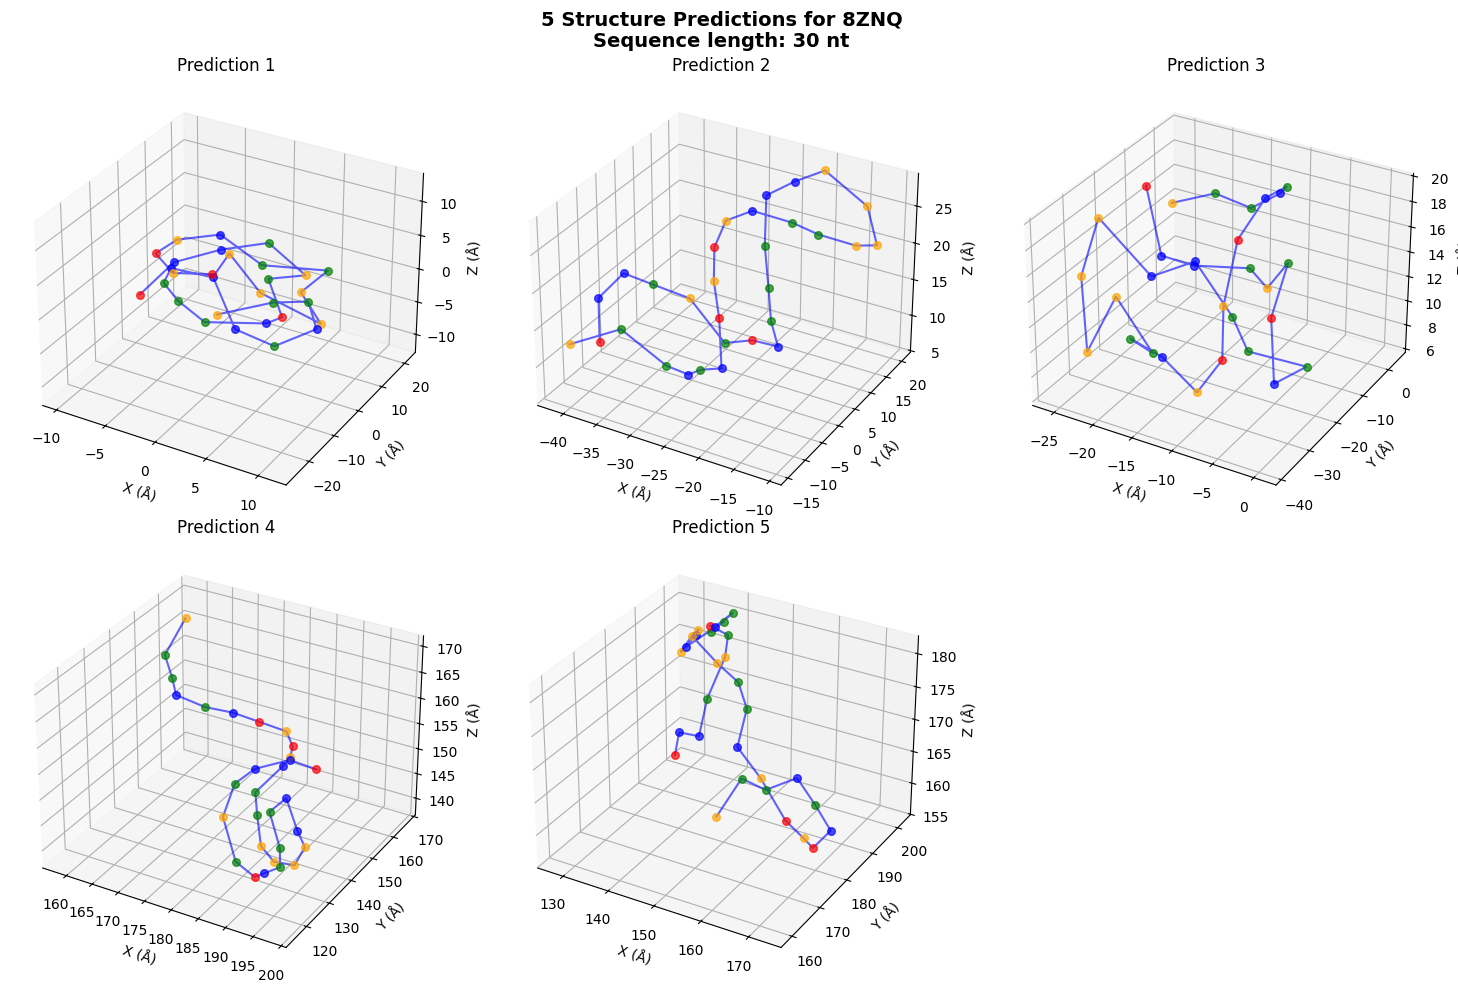

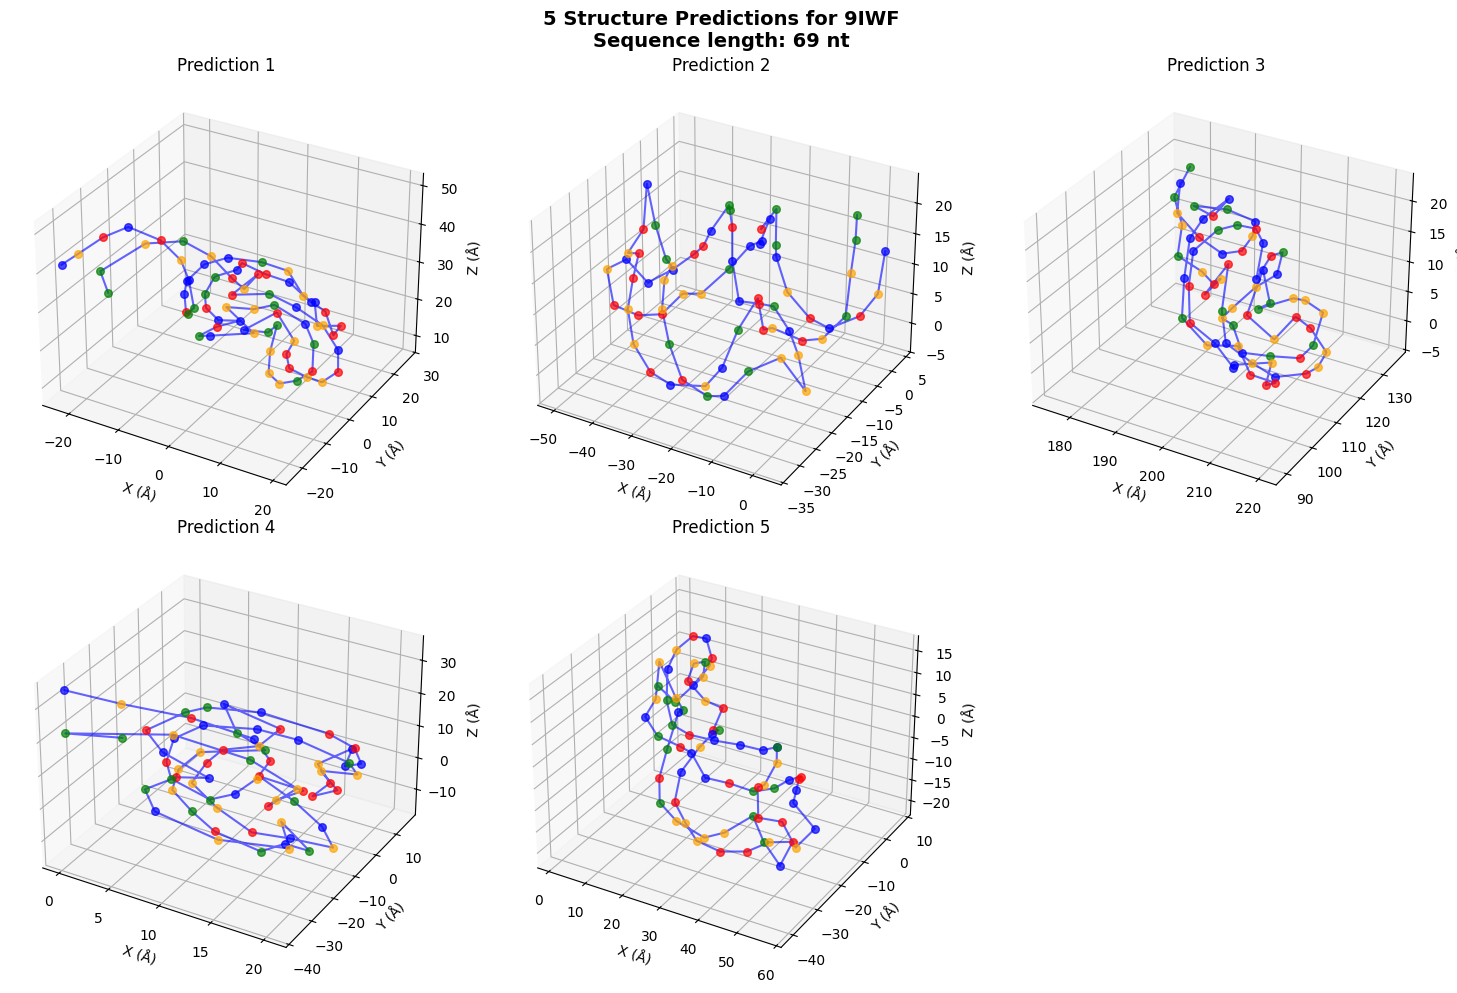

Processing target 6/28: 9E9Q (101 nt), elapsed: 5101.7s, est. remaining: 18706.4s
Processing target 11/28: 9G4R (47 nt), elapsed: 5108.2s, est. remaining: 7894.6s
Processing target 16/28: 9I9W (28 nt), elapsed: 5119.2s, est. remaining: 3839.4s
Processing target 21/28: 9WHV (80 nt), elapsed: 5122.9s, est. remaining: 1707.6s
Processing target 26/28: 9EBP (81 nt), elapsed: 5133.4s, est. remaining: 394.9s
Generated predictions for 28 RNA sequences
Total runtime: 5257.0 seconds


,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,8ZNQ_1,A,1,-3.508257,-20.768711,4.441455,-41.468449,-4.483310,8.775290,-25.102662,-9.965574,17.697936,192.905720,142.871654,154.708176,137.706794,182.483626,165.060313
1,8ZNQ_2,C,2,-0.733815,-18.435258,9.460651,-41.652112,-4.120104,14.742441,-24.820787,-5.869017,11.289598,189.154298,140.123546,156.488246,136.497202,185.901832,167.117364
2,8ZNQ_3,C,3,2.402406,-13.221142,10.860961,-37.255436,-4.909520,19.592174,-21.536931,-3.165405,10.520195,183.610612,138.111525,153.912355,141.579917,184.906099,167.904473
3,8ZNQ_4,G,4,6.135924,-10.080259,12.334327,-32.114410,-6.336077,20.023063,-15.679630,1.155668,10.506187,181.205338,135.046808,151.538692,141.661797,187.753515,172.698942
4,8ZNQ_5,U,5,8.432824,-4.998512,7.070227,-25.989875,-7.735294,20.392177,-11.864953,-3.228319,10.409691,180.756815,131.059535,146.538587,144.116262,190.119302,178.620625


In [12]:
# List to store all prediction records
all_predictions = []

# Set up time tracking
start_time = time.time()
total_targets = len(test_seqs)

plot_template_similarity_distribution(test_seqs, train_seqs, train_coords_dict, n_samples=50)

# For each sequence in the test set
for idx, row in test_seqs.iterrows():
    target_id = row['target_id']
    sequence = row['sequence']
    temporal_cutoff = row['temporal_cutoff'] if 'temporal_cutoff' in row else None
    
    # Progress tracking
    if idx % 5 == 0:
        elapsed = time.time() - start_time
        targets_processed = idx + 1
        if targets_processed > 0:
            avg_time_per_target = elapsed / targets_processed
            est_time_remaining = avg_time_per_target * (total_targets - targets_processed)
            print(f"Processing target {targets_processed}/{total_targets}: {target_id} ({len(sequence)} nt), "
                  f"elapsed: {elapsed:.1f}s, est. remaining: {est_time_remaining:.1f}s")
    
    # Generate 5 different structure predictions
    predictions = predict_rna_structures(sequence, target_id, train_seqs, train_coords_dict, 
                                        n_predictions=5, temporal_cutoff=temporal_cutoff)

    if idx < 2:  # Only plot first 2 to avoid too many plots
        plot_prediction_comparison(target_id, sequence, predictions)
    
    # For each residue in the sequence
    for j in range(len(sequence)):
        pred_row = {
            'ID': f"{target_id}_{j+1}",
            'resname': sequence[j],
            'resid': j + 1
        }
        
        # Add coordinates from all 5 predictions
        for i in range(5):
            pred_row[f'x_{i+1}'] = predictions[i][j][0]
            pred_row[f'y_{i+1}'] = predictions[i][j][1]
            pred_row[f'z_{i+1}'] = predictions[i][j][2]
        
        all_predictions.append(pred_row)

# Create DataFrame with predictions
submission_df = pd.DataFrame(all_predictions)

# Ensure the submission file has the correct format
column_order = ['ID', 'resname', 'resid']
for i in range(1, 6):
    for coord in ['x', 'y', 'z']:
        column_order.append(f'{coord}_{i}')
submission_df = submission_df[column_order]

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print(f"Generated predictions for {len(test_seqs)} RNA sequences")
print(f"Total runtime: {time.time() - start_time:.1f} seconds")
submission_df.head()